In [1]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
COMPARISON_FOLDER_INCODER = "cmp_v06/incoder_rebuttal"
COMPARISON_FOLDER_CODEGEN = "cmp_v06/codegen_rebuttal"
COMPARISON_FOLDER_GPTJ = "cmp_v06/gptj_rebuttal"
OUT_PAPER_FOLDER = "../data/paper_figures/rebuttal/"
MASTER_DATA_FOLDER = "../data/iclr2023data"

In [4]:
model_dfs = [] 

TARGET_FODLERS = [
    COMPARISON_FOLDER_INCODER,
    COMPARISON_FOLDER_CODEGEN, 
    COMPARISON_FOLDER_GPTJ
]

for folder in TARGET_FODLERS:
    # LOAD COMPARISON DATA
    path_comparison_dir = f'../data/comparisons/{folder}/'
    dfs = read_data_in_parallel(
        base_folder=path_comparison_dir,
        file_type_extension='.csv',
        read_function=pd.read_csv,
        n_processes=20,
        extra_filter_regex='plain_weights_.*'
    )
    df = pd.concat(dfs)
    all_comparisons = list(df["comparison_name"].unique())
    print(f"Loaded {len(all_comparisons)} comparisons from {folder}")
    df['model_folder_comparison'] = folder 
    model_dfs.append(df)

df_all_models = pd.concat(model_dfs)

df_incoder = model_dfs[0]
df_codegen = model_dfs[1]

n of data read:  9
Loaded 9 comparisons from cmp_v06/incoder_rebuttal
n of data read:  12
Loaded 12 comparisons from cmp_v06/codegen_rebuttal
n of data read:  9
Loaded 9 comparisons from cmp_v06/gptj_rebuttal


--------------------------------------------------------------------------------
cmp_v06/incoder_rebuttal
--------------------------------------------------------------------------------


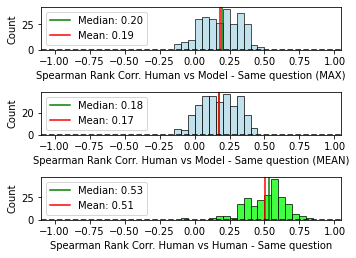

--------------------------------------------------------------------------------
cmp_v06/codegen_rebuttal
--------------------------------------------------------------------------------


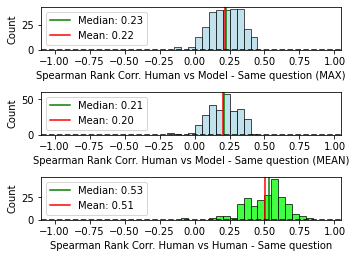

--------------------------------------------------------------------------------
cmp_v06/gptj_rebuttal
--------------------------------------------------------------------------------


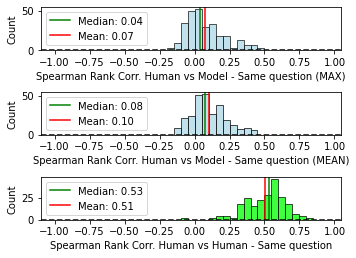

In [5]:
PREFIX = "plain_weights"
#PREFIX = "plain_weights_tokens"
#PREFIX = "plain_weights_tokens_at_least_a_letter"
# remove if pval is not significant
#PVAL_CUF = 0.05
for folder in TARGET_FODLERS:
    DF = df_all_models[df_all_models["model_folder_comparison"] == folder]
    # remove if pval is not significant
    #DF = DF[DF["pvalue"] < PVAL_CUF]
    vector_comparisons = [
        {
            "long": "Human vs Model - Same question (MAX)",
            'data': DF[
                (DF["comparison_name"].isin([f"{PREFIX}_meanfollowers"]))],
            'color': 'lightblue'
        },
        {
            "long": "Human vs Model - Same question (MEAN)",
            'data': DF[
                (DF["comparison_name"].isin([f"{PREFIX}_mean_meanfollowers"]))],
            'color': 'lightblue'
        },
        {
            "long": "Human vs Human - Same question",
            "data": DF[
                (DF["comparison_name"].isin([f"{PREFIX}_humans"]))],
            'color': 'lime'
        },
    ]
    print("-" * 80)
    print(folder)
    print("-" * 80)
    plot_histogram_in_parallel(
        vector_comparisons,
        col_name="correlation",
        common_prefix="Spearman Rank Corr.",
        bins=np.arange(-1, 1, 0.05),
        vertical_zero_line=True, 
        #out_path=os.path.join(OUT_PAPER_FOLDER, "vector_agreement_simple_incoder.pdf"),
    )
    plt.show()

## Debug single case

In [6]:
df_codegen_annotation = pd.read_csv("../data/annotations/2022-09-18/Answer Evaluation - Users - CODEGEN_SCORE.csv")
# rename filename to input_machine_filestem
df_codegen_annotation = df_codegen_annotation.rename(columns={"filename": "input_machine_filestem"})
# rename score to codegen_score
df_codegen_annotation = df_codegen_annotation.rename(columns={"score": "codegen_score"})
df_codegen_annotation.head()

,input_machine_filestem,model_name,n_try,codegen_score
0,tree_Q3.py_0_Salesforce_codegen-16B-multi,codegen-16B-multi,0,2
1,triangle_Q3.py_1_Salesforce_codegen-16B-multi,codegen-16B-multi,1,0
2,multithread_Q1.cpp_1_Salesforce_codegen-16B-multi,codegen-16B-multi,1,0
3,triangle_Q1.cs_1_Salesforce_codegen-16B-multi,codegen-16B-multi,1,2
4,hannoi_Q2.cpp_1_Salesforce_codegen-16B-multi,codegen-16B-multi,1,2


In [7]:
df_gptj_annotation = pd.read_csv("../data/annotations/2022-09-18/Answer Evaluation - Users - GPTJ_SCORE.csv")
# rename filename to input_machine_filestem
df_gptj_annotation = df_gptj_annotation.rename(columns={"filename": "input_machine_filestem"})
# rename score to gptj_score
df_gptj_annotation = df_gptj_annotation.rename(columns={"score": "gptj_score"})
df_gptj_annotation.head()

,input_machine_filestem,model_name,n_try,gptj_score
0,Nqueens_Q1.cpp_0_EleutherAI_gpt-j-6B,gptj-6B,0,0
1,Nqueens_Q1.cpp_1_EleutherAI_gpt-j-6B,gptj-6B,1,0
2,Nqueens_Q1.cpp_2_EleutherAI_gpt-j-6B,gptj-6B,2,0
3,Nqueens_Q1.cs_0_EleutherAI_gpt-j-6B,gptj-6B,0,0
4,Nqueens_Q1.cs_1_EleutherAI_gpt-j-6B,gptj-6B,1,0


In [8]:
df_incoder_annotation = pd.read_csv("../data/annotations/2022-11-11/Answer Evaluation - Users - INCODER_SCORE.csv")
# rename filename to input_machine_filestem
df_incoder_annotation = df_incoder_annotation.rename(columns={"filename": "input_machine_filestem"})
# rename score to incoder_score
df_incoder_annotation = df_incoder_annotation.rename(columns={"score": "incoder_score"})
df_incoder_annotation.head()

,input_machine_filestem,model_name,n_try,incoder_score
0,triangle_Q3.py_2_facebook_incoder-6B,facebook_incoder-6B,2,0
1,triangle_Q3.py_1_facebook_incoder-6B,facebook_incoder-6B,1,0
2,triangle_Q3.py_0_facebook_incoder-6B,facebook_incoder-6B,0,0
3,triangle_Q3.cs_2_facebook_incoder-6B,facebook_incoder-6B,2,0
4,triangle_Q3.cs_1_facebook_incoder-6B,facebook_incoder-6B,1,0


In [9]:
df_human_annotation = pd.read_csv("../data/annotations/2022-09-18/Answer Evaluation - Users - HUMAN_SCORE.csv")
# rename unique_data_id to input_human_filestem
df_human_annotation = df_human_annotation.rename(columns={"unique_data_id": "input_human_filestem"})
# rename score to human_score
df_human_annotation = df_human_annotation.rename(columns={"score": "human_score"})
df_human_annotation.head()

,input_human_filestem,user,task_number,filename,human_score
0,d41dd8,UbeerU,3,multithread_Q2.py,0
1,6695fa,UpassionU,0,hannoi_Q3.cs,2
2,5403f5,UcamelionU,0,hannoi_Q1.py,2
3,0d7601,UsleepU,0,hannoi_Q2.py,2
4,f936ca,UscoopU,3,triangle_Q3.cs,1


# Study Agreement on Good vs Bad Answer Pairs

In [10]:
PREFIX = "plain_weights"
#PREFIX = "plain_weights_tokens_at_least_a_letter"
df_selection = df_all_models[df_all_models["comparison_name"].isin(
    [
        f"{PREFIX}_meanfollowers", 
        #f"{PREFIX}_mean_meanfollowers", 
        f"{PREFIX}_humans"])]

## Human vs Human vs Performance

In [11]:
df_codegen_4_humans = df_selection[
    df_selection["model_folder_comparison"] == COMPARISON_FOLDER_CODEGEN]
print(df_codegen_4_humans["model_folder_comparison"].unique())
# keep only if the input_machine_filestem is not null
df_codegen_4_humans = df_codegen_4_humans[
    df_codegen_4_humans["human_a"].notnull() & df_codegen_4_humans["human_b"].notnull()]
# merge the df_codegen_annotation and df_human_annotation to df_codegen
df_human_annotation_a = df_human_annotation.rename(
    columns={"input_human_filestem": "human_a"})
df_human_annotation_b = df_human_annotation.rename(
    columns={"input_human_filestem": "human_b", "human_score": "human_other_score"})
df_codegen_4_humans = df_codegen_4_humans.merge(
    df_human_annotation_a, on="human_a")
df_codegen_4_humans = df_codegen_4_humans.merge(
    df_human_annotation_b, on="human_b")
df_codegen_4_humans.head()

['cmp_v06/codegen_rebuttal']


,comparison_name,comparison_function,source_code,user_name,task_number_x,input_human_filestem,input_machine_filestem,comparison_type,correlation,pvalue,...,transformation_2.name,model_folder_comparison,user_x,task_number_y,filename_x,human_score,user_y,task_number,filename_y,human_other_score
0,plain_weights_humans,spearman_rank,csharp/hannoi_Q1.cs,NaN,NaN,NaN,NaN,vector,0.456531,6.652420e-51,...,NaN,cmp_v06/codegen_rebuttal,UsurfU,0,hannoi_Q1.cs,0,UrideU,0,hannoi_Q1.cs,0
1,plain_weights_humans,spearman_rank,csharp/hannoi_Q1.cs,NaN,NaN,NaN,NaN,vector,0.425803,7.991779e-44,...,NaN,cmp_v06/codegen_rebuttal,UDuckU,0,hannoi_Q1.cs,1,UrideU,0,hannoi_Q1.cs,0
2,plain_weights_humans,spearman_rank,csharp/hannoi_Q1.cs,NaN,NaN,NaN,NaN,vector,0.480972,4.483784e-57,...,NaN,cmp_v06/codegen_rebuttal,UboatU,0,hannoi_Q1.cs,1,UrideU,0,hannoi_Q1.cs,0
3,plain_weights_humans,spearman_rank,csharp/hannoi_Q1.cs,NaN,NaN,NaN,NaN,vector,0.559367,1.280597e-80,...,NaN,cmp_v06/codegen_rebuttal,UsurfU,0,hannoi_Q1.cs,0,UDuckU,0,hannoi_Q1.cs,1
4,plain_weights_humans,spearman_rank,csharp/hannoi_Q1.cs,NaN,NaN,NaN,NaN,vector,0.425803,7.991779e-44,...,NaN,cmp_v06/codegen_rebuttal,UrideU,0,hannoi_Q1.cs,0,UDuckU,0,hannoi_Q1.cs,1


In [12]:
# for each combination of human_score and codegen_score, compute the mean correlation
df_codegen_4_humans_agg = df_codegen_4_humans.groupby(["human_score", "human_other_score"]).agg({"correlation": ["mean", "var", "count"]}).reset_index()
df_codegen_4_humans_agg.head(9)

human_score human_other_score correlation                
                                       mean       var count
0           0                 0    0.488095  0.012955    44
1           0                 1    0.582142  0.015746     9
2           0                 2    0.532350  0.020127    25
3           1                 0    0.582142  0.015746     9
4           1                 1    0.652200  0.008413    16
5           1                 2    0.496463  0.029521    20
6           2                 0    0.532350  0.020127    25
7           2                 1    0.496463  0.029521    20
8           2                 2    0.436570  0.019305    56

## Auxiliary Functions

In [21]:
def visualize_matrix(dfs: List[pd.DataFrame], vmax: float = None, vmin: float = None,):
    """Visualize a matrix of correlation based on model-vs-human score."""
    n_diagrams = len(dfs)
    global_max = max([df["correlation"]["mean"].max() for df in dfs])
    global_min = min([df["correlation"]["mean"].min() for df in dfs])
    if vmax is None:
        vmax = global_max
    if vmin is None:
        vmin = global_min
    fig, axes = plt.subplots(1, n_diagrams, figsize=(3 * n_diagrams, 3))
    for i, df in enumerate(dfs):
        ax = axes[i]
        corr_matrix = np.zeros((3, 3))
        # pick column name with "_score" but not "human_score"
        model_col = [
            col for col in df.columns 
            if "_score" in col[0] and "human_score" not in col[0]][0][0]
        for i, row in df.iterrows():
            human_score = int(row["human_score"])
            codegen_score = int(row[model_col])
            corr_matrix[human_score, codegen_score] = row["correlation"]["mean"]
        sns.heatmap(
            corr_matrix,
            annot=True,
            fmt=".2f",
            xticklabels=["Wrong", "Partial", "Correct"],
            yticklabels=["Wrong", "Partial", "Correct"],
            cmap="Greens" if "human" in model_col else "Reds",
            vmax=vmax,
            vmin=vmin,
            ax=ax,
        )
        ax.set_ylabel("Human Score")
        ax.set_xlabel(model_col.replace("_score", " Score"))
    plt.tight_layout()
    return fig, axes

## Inspect CodeGen vs Human

In [14]:
df_codegen = df_selection[
    df_selection["model_folder_comparison"] == COMPARISON_FOLDER_CODEGEN]
print(df_codegen["model_folder_comparison"].unique())
# keep only if the input_machine_filestem is not null
df_codegen = df_codegen[df_codegen["input_machine_filestem"].notnull()]
# merge the df_codegen_annotation and df_human_annotation to df_codegen
df_codegen = df_codegen.merge(df_codegen_annotation, on="input_machine_filestem")
df_codegen = df_codegen.merge(df_human_annotation, on="input_human_filestem")
df_codegen.head()

['cmp_v06/codegen_rebuttal']


,comparison_name,comparison_function,source_code,user_name,task_number_x,input_human_filestem,input_machine_filestem,comparison_type,correlation,pvalue,...,human_b,transformation_2.name,model_folder_comparison,model_name,n_try,codegen_score,user,task_number_y,filename,human_score
0,plain_weights_meanfollowers,spearman_rank,hannoi_Q1.cs,UsurfU,0.0,f4bbec,hannoi_Q1.cs_2_Salesforce_codegen-16B-multi,vector,0.319036,3.541813e-24,...,NaN,NaN,cmp_v06/codegen_rebuttal,codegen-16B-multi,2,0,UsurfU,0,hannoi_Q1.cs,0
1,plain_weights_meanfollowers,spearman_rank,hannoi_Q1.cs,UsurfU,0.0,f4bbec,hannoi_Q1.cs_1_Salesforce_codegen-16B-multi,vector,0.333623,2.047723e-26,...,NaN,NaN,cmp_v06/codegen_rebuttal,codegen-16B-multi,1,0,UsurfU,0,hannoi_Q1.cs,0
2,plain_weights_meanfollowers,spearman_rank,hannoi_Q1.cs,UsurfU,0.0,f4bbec,hannoi_Q1.cs_0_Salesforce_codegen-16B-multi,vector,0.341516,1.119088e-27,...,NaN,NaN,cmp_v06/codegen_rebuttal,codegen-16B-multi,0,0,UsurfU,0,hannoi_Q1.cs,0
3,plain_weights_meanfollowers,spearman_rank,hannoi_Q1.cs,UrideU,0.0,b7971a,hannoi_Q1.cs_2_Salesforce_codegen-16B-multi,vector,0.245825,1.079230e-14,...,NaN,NaN,cmp_v06/codegen_rebuttal,codegen-16B-multi,2,0,UrideU,0,hannoi_Q1.cs,0
4,plain_weights_meanfollowers,spearman_rank,hannoi_Q1.cs,UrideU,0.0,b7971a,hannoi_Q1.cs_1_Salesforce_codegen-16B-multi,vector,0.240717,3.908577e-14,...,NaN,NaN,cmp_v06/codegen_rebuttal,codegen-16B-multi,1,0,UrideU,0,hannoi_Q1.cs,0


In [15]:
# for each combination of human_score and codegen_score, compute the mean correlation
df_codegen_agg = df_codegen.groupby(["human_score", "codegen_score"]).agg({"correlation": ["mean", "var", "count"]}).reset_index()
df_codegen_agg.head(9)

human_score codegen_score correlation                
                                   mean       var count
0           0             0    0.198075  0.012649    67
1           0             1    0.113416  0.020063    12
2           0             2    0.179585  0.013347     5
3           1             0    0.267824  0.009393    39
4           1             1    0.219310  0.008071    13
5           1             2    0.212343  0.025571    14
6           2             0    0.230322  0.012078    76
7           2             1    0.203017  0.010214    14
8           2             2    0.223115  0.010550    36

## Inspect GPTJ vs Human

In [16]:
df_gptj = df_selection[
    df_selection["model_folder_comparison"] == COMPARISON_FOLDER_GPTJ]
print(df_gptj["model_folder_comparison"].unique())
# keep only if the input_machine_filestem is not null
df_gptj = df_gptj[df_gptj["input_machine_filestem"].notnull()]
# merge the df_gptj_annotation and df_human_annotation to df_gptj
df_gptj = df_gptj.merge(df_gptj_annotation, on="input_machine_filestem")
df_gptj = df_gptj.merge(df_human_annotation, on="input_human_filestem")
df_gptj.head()

['cmp_v06/gptj_rebuttal']


,comparison_name,comparison_function,source_code,user_name,task_number_x,input_human_filestem,input_machine_filestem,comparison_type,correlation,pvalue,...,human_b,transformation_2.name,model_folder_comparison,model_name,n_try,gptj_score,user,task_number_y,filename,human_score
0,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbagU,2.0,0480e5,tree_Q2.py_0_EleutherAI_gpt-j-6B,vector,0.027768,0.247542,...,NaN,NaN,cmp_v06/gptj_rebuttal,gptj-6B,0,0,UbagU,2,tree_Q2.py,0
1,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbagU,2.0,0480e5,tree_Q2.py_1_EleutherAI_gpt-j-6B,vector,0.017465,0.467095,...,NaN,NaN,cmp_v06/gptj_rebuttal,gptj-6B,1,0,UbagU,2,tree_Q2.py,0
2,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbagU,2.0,0480e5,tree_Q2.py_2_EleutherAI_gpt-j-6B,vector,0.024610,0.305467,...,NaN,NaN,cmp_v06/gptj_rebuttal,gptj-6B,2,0,UbagU,2,tree_Q2.py,0
3,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbottleU,1.0,5a70af,tree_Q2.py_0_EleutherAI_gpt-j-6B,vector,0.050514,0.035333,...,NaN,NaN,cmp_v06/gptj_rebuttal,gptj-6B,0,0,UbottleU,1,tree_Q2.py,0
4,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbottleU,1.0,5a70af,tree_Q2.py_1_EleutherAI_gpt-j-6B,vector,0.035913,0.134722,...,NaN,NaN,cmp_v06/gptj_rebuttal,gptj-6B,1,0,UbottleU,1,tree_Q2.py,0


In [17]:
# for each combination of human_score and gpj_score, compute the mean correlation
df_gptj_agg = df_gptj.groupby(["human_score", "gptj_score"]).agg({"correlation": ["mean", "var", "count"]}).reset_index()
df_gptj_agg.head(20)

human_score gptj_score correlation                
                                mean       var count
0           0          0    0.052541  0.011929    55
1           0          1    0.015985  0.010327    15
2           0          2    0.053347  0.036048    14
3           1          0    0.135612  0.029853    41
4           1          1    0.019730  0.016266    12
5           1          2   -0.038802  0.003665    13
6           2          0    0.076901  0.014008    74
7           2          1    0.071761  0.010897     9
8           2          2    0.112980  0.022509    43

## Inspect Incoder vs Human

In [18]:
df_incoder = df_selection[
    df_selection["model_folder_comparison"] == COMPARISON_FOLDER_INCODER]
print(df_incoder["model_folder_comparison"].unique())
# keep only if the input_machine_filestem is not null
df_incoder = df_incoder[df_incoder["input_machine_filestem"].notnull()]
# merge the df_incoder_annotation and df_human_annotation to df_incoder
df_incoder = df_incoder.merge(df_incoder_annotation, on="input_machine_filestem")
df_incoder = df_incoder.merge(df_human_annotation, on="input_human_filestem")
df_incoder.head()

['cmp_v06/incoder_rebuttal']


,comparison_name,comparison_function,source_code,user_name,task_number_x,input_human_filestem,input_machine_filestem,comparison_type,correlation,pvalue,...,human_b,transformation_2.name,model_folder_comparison,model_name,n_try,incoder_score,user,task_number_y,filename,human_score
0,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbagU,2.0,0480e5,tree_Q2.py_0_facebook_incoder-6B,vector,0.088499,0.000223,...,NaN,NaN,cmp_v06/incoder_rebuttal,facebook_incoder-6B,0,0,UbagU,2,tree_Q2.py,0
1,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbagU,2.0,0480e5,tree_Q2.py_1_facebook_incoder-6B,vector,0.067566,0.004857,...,NaN,NaN,cmp_v06/incoder_rebuttal,facebook_incoder-6B,1,0,UbagU,2,tree_Q2.py,0
2,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbagU,2.0,0480e5,tree_Q2.py_2_facebook_incoder-6B,vector,0.069964,0.003539,...,NaN,NaN,cmp_v06/incoder_rebuttal,facebook_incoder-6B,2,0,UbagU,2,tree_Q2.py,0
3,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbottleU,1.0,5a70af,tree_Q2.py_0_facebook_incoder-6B,vector,0.049175,0.040494,...,NaN,NaN,cmp_v06/incoder_rebuttal,facebook_incoder-6B,0,0,UbottleU,1,tree_Q2.py,0
4,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,UbottleU,1.0,5a70af,tree_Q2.py_1_facebook_incoder-6B,vector,0.046424,0.053120,...,NaN,NaN,cmp_v06/incoder_rebuttal,facebook_incoder-6B,1,0,UbottleU,1,tree_Q2.py,0


In [19]:
# for each combination of human_score and incoder_score, compute the mean correlation
df_incoder_agg = df_incoder.groupby(["human_score", "incoder_score"]).agg({"correlation": ["mean", "var", "count"]}).reset_index()
df_incoder_agg.head(20)

human_score incoder_score correlation                
                                   mean       var count
0           0             0    0.137153  0.021986    67
1           0             1    0.118250  0.012066    10
2           0             2    0.171663  0.015490     7
3           1             0    0.208257  0.017803    39
4           1             1    0.207590  0.014873    17
5           1             2    0.309867  0.004829    10
6           2             0    0.175948  0.019929    81
7           2             1    0.229062  0.018186    10
8           2             2    0.234557  0.008736    35

## VIsualize Results

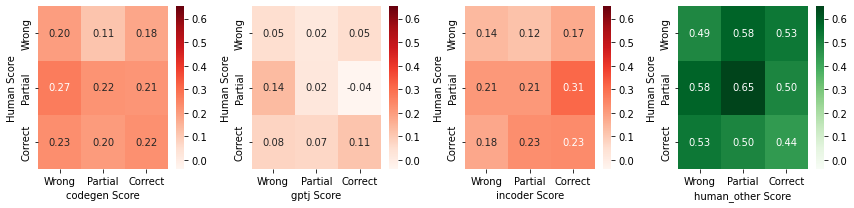

In [22]:
fig, axes = visualize_matrix(
    dfs=[df_codegen_agg, df_gptj_agg, df_incoder_agg, df_codegen_4_humans_agg],
)
# save figure
fig.savefig(os.path.join(OUT_PAPER_FOLDER, "agreement_vs_accuracy.pdf"), dpi=300)

# Other

In [35]:
df_incoder = df_selection[
    df_selection["model_folder_comparison"] == COMPARISON_FOLDER_INCODER]
print(df_incoder["model_folder_comparison"].unique())
# set seed for reproducibility
np.random.seed(42)
# pick a random record
random_record = df_incoder.sample(1).iloc[0]
print("input_human_filestem:", random_record["input_human_filestem"])
print("input_machine_filestem:", random_record["input_machine_filestem"])

def get_two_vectors(record: List[Dict[str, Any]]) -> Tuple[List[float], List[float]]:
    """Get the two compared vectors: one from human, and one from model."""
    comparison_name = record["comparison_name"]

    human_folder = "." + record["human_att_folder"]
    human_subfolder = os.path.join(human_folder, record["provenance.human.subfolder"])
    human_in_filepath = os.path.join(human_subfolder, record["input_human_filestem"]) + ".npy"
    in_human = np.load(human_in_filepath)
    human_metadata_filepath = os.path.join(human_subfolder, "metadata", record["input_human_filestem"]) + ".json"
    human_metadata = load_json_file(human_metadata_filepath)

    model_folder = "." + record["machine_att_folder"]
    all_model_subfolders = record["provenance.machine"]
    print("all_model_subfolders:", all_model_subfolders)
    print(type(all_model_subfolders))
    import ast
    all_model_subfolders = ast.literal_eval(all_model_subfolders)
    print(type(all_model_subfolders))
    # pick the subfolder which has the suffix matching the end of the 
    # comparison name
    model_subfolder = [
        subfolder for subfolder in all_model_subfolders
        if comparison_name.endswith(subfolder["suffix"])
    ][0]['subfolder']
    model_in_filepath = os.path.join(model_folder, model_subfolder, record["input_machine_filestem"]) + ".npy"
    in_model = np.load(model_in_filepath)
    model_metadata_filepath = os.path.join(model_folder, "metadata", record["input_machine_filestem"]) + ".json"
    model_metadata = load_json_file(model_metadata_filepath)

    print("human_in_filepath:", human_in_filepath)
    print("model_in_filepath:", model_in_filepath)
    print("in_human.shape:", in_human.shape)
    print("in_model.shape:", in_model.shape)
    return in_human, in_model, human_metadata, model_metadata
    #print(all_model_subfolders)

in_human, in_model, human_metadata, model_metadata = get_two_vectors(random_record)


['cmp_v06/incoder_rebuttal']
input_human_filestem: nan
input_machine_filestem: nan


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'float'

In [38]:
human_tokens = [t['t'] for t in human_metadata]
print("n_human tokens: ", len(human_tokens))
print("".join(human_tokens))

n_human tokens:  176
# ****************************************************************************

# In the Tower of Hanoi problem you have to move all the disks

# from the left hand post to the right hand post.

# You can only move the disks one at a time and you can never

# place a bigger disk on a smaller disk.


def TowerOfHanoi(n, from_rod, to_rod, aux_rod):
    if n == 0:
        return
    TowerOfHanoi(n-1, from_rod, aux_rod, to_rod)
    print("Move disk", n, "from rod", from_rod, "to rod", to_rod)
    TowerOfHanoi(n-1, aux_rod, to_rod, from_rod)


n = 4
TowerOfHanoi(n, 'A', 'C', 'B')


# Questions: How does the algorithm moves disks from the starting rod to the

# ending rod?

# Answer:



In [43]:
model_tokens = model_metadata['tokens_all']
print("n_model tokens: ", len(model_tokens))
print("".join(model_tokens).replace("Ġ", " ").replace("Ċ", "\n"))

n_model tokens:  276
<|endoftext|># ****************************************************************************

# In the Tower of Hanoi problem you have to move all the disks

# from the left hand post to the right hand post.

# You can only move the disks one at a time and you can never

# place a bigger disk on a smaller disk.


def TowerOfHanoi(n, from_rod, to_rod, aux_rod):
    if n == 0:
        return
    TowerOfHanoi(n-1, from_rod, aux_rod, to_rod)
    print("Move disk", n, "from rod", from_rod, "to rod", to_rod)
    TowerOfHanoi(n-1, aux_rod, to_rod, from_rod)


n = 4
TowerOfHanoi(n, 'A', 'C', 'B')


# Questions: How does the algorithm moves disks from the starting rod to the

# ending rod?

# Answer:

# It moves disks from the starting rod to the ending rod one at a time.

# Move disk 1 from rod A to rod B
# Move disk 2 from rod B to rod C
# Move disk 3 from rod C to rod A
# Move disk 4 from rod A to rod B

# Move disk 1 from rod B to rod C
# Move disk 2 from rod C to rod A


In [8]:
PREDICTION_FILENAME = "multithread_Q2.py_2_facebook_incoder-6B.json"
BASE_PATH = "../data/model_output/exp_v10/incoder_rebuttal/"
METADATA_PATH = os.path.join(BASE_PATH, "metadata")
VECTOR_PATH = os.path.join(BASE_PATH, "vector_naive_max_plus_mean_of_followers")

metadata = load_json_file(os.path.join(METADATA_PATH, PREDICTION_FILENAME))
vector = np.load(os.path.join(VECTOR_PATH, PREDICTION_FILENAME).replace(".json", ".npy"))

metadata['tokens_all']


{'tokens_all': ['<|endoftext|>',
  '#Ġ',
  '********************************',
  '************************************************',
  '********',
  '******',
  '*',
  'ĊĊ',
  '#Ġ',
  'InĠtheĠ',
  'Consum',
  'er-',
  'Produ',
  'c',
  'erĠ',
  'problem,Ġ',
  'twoĠ',
  'thread',
  'sĠ',
  'types,Ġ',
  'calledĠ',
  'produ',
  'cer',
  'sĠand',
  'ĊĊ',
  '#Ġ',
  'consum',
  'er',
  's,Ġ',
  'shareĠ',
  'theĠsameĠ',
  'memoryĠ',
  'bufferĠ',
  'thatĠisĠ',
  'ofĠ',
  'fixed-',
  'size.',
  'ĊĊ',
  '#ĠTheĠ',
  'produ',
  'cer',
  'sĠ',
  'addĠ',
  'data',
  'ĠtoĠtheĠ',
  'buffer,Ġ',
  'where',
  'asĠtheĠ',
  'consum',
  'ersĠ',
  'remove',
  'sĠ',
  'data.',
  'ĊĊĊ',
  'importĠthreading',
  'Ċ',
  'importĠtime',
  'Ċ',
  'importĠrandom',
  'Ċ',
  'importĠlogging',
  'ĊĊĊ',
  'logging.basicConfig(',
  'level=',
  'logging.DEBUG',
  ',',
  'Ċ',
  'ĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠ',
  "format='",
  '(',
  '%(',
  'thread',
  'Name)',
  '-9',
  's)Ġ',
  '%(message)',
  "s',",
  ')',
  'ĊĊĊ',
  'classĠ',
  

In [26]:
sorted(list(df_codegen["comparison_name"].unique()))

['plain_weights_tokens_humans',
 'plain_weights_tokens_mean_meanfollowers',
 'plain_weights_tokens_meanfollowers']

In [25]:
df_incoder.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1552 entries, ('plain_weights_humans', 0) to ('plain_weights_tokens_meanfollowers', 275)
Data columns (total 36 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   comparison_name                                     1552 non-null   object 
 1   comparison_function                                 1552 non-null   object 
 2   source_code                                         1552 non-null   object 
 3   user_name_a                                         448 non-null    object 
 4   task_number_a                                       448 non-null    float64
 5   user_name_b                                         448 non-null    object 
 6   task_number_b                                       448 non-null    float64
 7   human_a                                             448 non-null    object 
 8   human_b      

In [22]:
# when saving
# relevant_columns = [
#     "comparison_name",
#     "input_human_filestem",
#     "input_machine_filestem",
#     "spearman_res.corr", 'spearman_res.pval', 'spearman_res.token_index',
#     "top_3.token_index", 'top_3.value',
#     'top_3.top_k_machine', 'top_3.top_k_groud_truth',
#     'human_a', 'human_b', 
# ]

# df_codegen_slim = df_codegen[relevant_columns]
# # print the space occupied in memory
# print(f"df_codegen_slim: {df_codegen_slim.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
# # save in the MASTER_DATA_FOLDER
# df_codegen_slim.to_csv(os.path.join(MASTER_DATA_FOLDER, "df_codegen_comparisons_and_abl_study.csv"), index=False)

# char-level

In [10]:
DF = df_incoder

vector_comparisons = [
    {
        "short": "human_vs_model_incoder_same_question",
        "long": "Human vs Model - Same question (MAX)",
        'data': DF[
            (DF["comparison_name"].isin(["plain_weights_meanfollowers"]))],
        'color': 'lightblue'
    },
    {
        "short": "human_vs_model_incoder_same_question",
        "long": "Human vs Model - Same question (MEAN)",
        'data': DF[
            (DF["comparison_name"].isin(["plain_weights_mean_meanfollowers"]))],
        'color': 'lightblue'
    },
    {
        "short": "human_vs_human_same_question",
        "long": "Human vs Human - Same question",
        "data": DF[
            (DF["comparison_name"].isin(["plain_weights_humans"]))],
        'color': 'lime'
    },
]

# Token-level

In [20]:
DF = df_incoder

vector_comparisons = [
    {
        "short": "human_vs_model_incoder_same_question",
        "long": "Human vs Model - Same question (MAX)",
        'data': DF[
            (DF["comparison_name"].isin(["plain_weights_tokens_meanfollowers"]))],
        'color': 'lightblue'
    },
    {
        "short": "human_vs_model_incoder_same_question",
        "long": "Human vs Model - Same question (MEAN)",
        'data': DF[
            (DF["comparison_name"].isin(["plain_weights_tokens_mean_meanfollowers"]))],
        'color': 'lightblue'
    },
    {
        "short": "human_vs_human_same_question",
        "long": "Human vs Human - Same question",
        "data": DF[
            (DF["comparison_name"].isin(["plain_weights_tokens_humans"]))],
        'color': 'lime'
    },
]

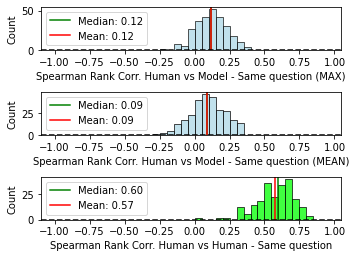

In [21]:
plot_histogram_in_parallel(
    vector_comparisons,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    vertical_zero_line=True, 
    #out_path=os.path.join(OUT_PAPER_FOLDER, "vector_agreement_simple_incoder.pdf"),
)

In [27]:
DF = df_codegen

vector_comparisons = [
    {
        "short": "human_vs_model_incoder_same_question",
        "long": "Human vs Model - Same question (MAX)",
        'data': DF[
            (DF["comparison_name"].isin(["plain_weights_tokens_meanfollowers"]))],
        'color': 'lightblue'
    },
    {
        "short": "human_vs_model_incoder_same_question",
        "long": "Human vs Model - Same question (MEAN)",
        'data': DF[
            (DF["comparison_name"].isin(["plain_weights_tokens_mean_meanfollowers"]))],
        'color': 'lightblue'
    },
    {
        "short": "human_vs_human_same_question",
        "long": "Human vs Human - Same question",
        "data": DF[
            (DF["comparison_name"].isin(["plain_weights_tokens_humans"]))],
        'color': 'lime'
    },
]

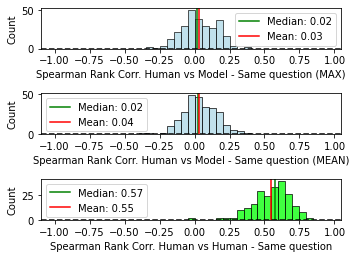

In [28]:
plot_histogram_in_parallel(
    vector_comparisons,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    vertical_zero_line=True, 
    #out_path=os.path.join(OUT_PAPER_FOLDER, "vector_agreement_simple_incoder.pdf"),
)

In [13]:
vector = np.load(
    "../data/eye_tracking_attention/eye_v10/att_weights_Salesforce_codegen-16B-multi/0d7601.npy"
    #"../data/model_output/exp_v10/incoder/naive_mean/hannoi_Q1.cpp_facebook_incoder-6B.npy"
)
vector.shape

(216,)

In [14]:
json_path = "../data/eye_tracking_attention/eye_v10/att_weights_Salesforce_codegen-16B-multi/metadata/0d7601.json"
with open(json_path, "r") as f:
    metadata = json.load(f)
len(metadata)

216

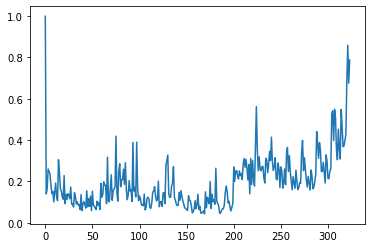

In [13]:
plt.plot(vector)

In [27]:
json_path = "../data/model_output/exp_v10/incoder/metadata/hannoi_Q1.cpp_facebook_incoder-6B.json"
with open(json_path, "r") as f:
    metadata = json.load(f)
tokens = metadata["tokens_all"]
print(tokens[5])
print(len(tokens[5]))

ĊĊĊ
3
